In [1]:
import os
import pandas as pd
import numpy as np

# Pré-processamento

In [2]:
def fix_col_names(_df: pd.DataFrame, silent: bool = True) -> pd.DataFrame:
    ''' Strips and lowercases DataFrame columns '''
    df = _df.copy()
    og_cols = df.columns.to_list()

    df.columns = df.columns \
        .str.lower() \
        .str.strip()
    
    max_col_name_size = len(max(og_cols, key=lambda x: len(x))) + 5
    if not silent:
        for og, new in zip(og_cols, df.columns.to_list()):
            print(f'{og: <{max_col_name_size}} -> {new}')

    return df

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
def preprocess(
    train_set: pd.DataFrame, 
    submission_set: pd.DataFrame,
    target: str,
    encode_target: bool = False,
    corr_threshold: float = None,
    random_state: int = 22
) -> (pd.DataFrame, ...):
    
    # col names
    df_train = fix_col_names(train_set)
    df_test = fix_col_names(submission_set)

    # bool to numeric
    non_numeric_or_object = df_train.select_dtypes(exclude=[np.number, object]).columns
    df_train[non_numeric_or_object] = df_train[non_numeric_or_object].astype(int)

    non_numeric_or_object = df_test.select_dtypes(exclude=[np.number, object]).columns
    df_test[non_numeric_or_object] = df_test[non_numeric_or_object].astype(int)
    
    # cols with values that contain '%' or 'Own' to numeric
    for _df in [df_train, df_test]:
        for col in _df.select_dtypes(object).columns:
            if any(_df[col].str.contains('Own', na=False)):
                _df[col] = _df[col].str.extract('[Own]?(\d+.\d*)').astype(float)
                continue
            if any(_df[col].str.contains('%', na=False)):
                _df[col] = _df[col].str.extract('(\d+.\d*)[%]').astype(float)
                continue
    
    # remove columns with values that contain ':' or '-'
    for _df in [df_train, df_test]:
        for col in _df.select_dtypes(object).columns:
            if any(_df[col].str.contains(':', na=False)):
                _df.drop(col, axis=1, inplace=True)
                continue
            if any(_df[col].str.contains('-', na=False)):
                _df.drop(col, axis=1, inplace=True)
                continue
    
    # removing additional columns
    cols_to_drop = ['gs_game_day_of_week', 'gs_game_date', 'gs_game_location', 'gs_week_number']
    for _df in [df_train, df_test]:
        _df.drop(cols_to_drop, axis=1, inplace=True)

    if encode_target:
        target_encoder = {'L': 0, 'W': 1}
        df_train[target] = df_train[target].map(target_encoder)
        df_test[target] = df_test[target].map(target_encoder)
        
    # col names
    cat_cols = df_train.select_dtypes(object).columns.tolist()
    num_cols = df_train.select_dtypes(np.number).columns.tolist()
    
    # correlation threshold
    if bool(corr_threshold) & encode_target:
        _corr = df_train[num_cols].corrwith(df_train[target])
        correlated_cols = _corr[(_corr >= corr_threshold) & (_corr != 1)].index.tolist()
    else:
        correlated_cols = num_cols
   
    # x & y
    cols_to_use = cat_cols + correlated_cols
    if 'gs_id' not in cols_to_use:
        cols_to_use.append('gs_id')
    
    if target in cols_to_use:
        cols_to_use.remove(target)

    x_final = df_train.copy().drop(target, axis=1)
    x_train = x_final[cols_to_use]
    y_train = df_train[target]
    
    x_test = df_test[cols_to_use]
    y_test = df_test[target]

    return x_train, x_test, y_train, y_test

# Calculo das métricas da predição

In [5]:
from pprint import pprint
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from datetime import datetime

all_scores = {}

def show_scores(scores: dict = all_scores):
    display(pd.DataFrame(all_scores.values()))

def calculate_scores(
    model_name: str, 
    y_test: pd.Series, pred: np.ndarray, 
    pos_label: str or int = 1,
    score_list: list = all_scores,
    display_confusion_matrix: bool = True,
    display_scores: bool = True
    ):
    cf_mx = ConfusionMatrixDisplay.from_predictions(y_test, pred)
    acc = accuracy_score(y_test, pred)
    bacc = balanced_accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, pos_label=pos_label)
    recall = recall_score(y_test, pred, pos_label=pos_label)
    
    model_scores = {
        'model_name': model_name,
        'acc': acc,
        'bacc': bacc,
        'precision': precision,
        'recall': recall
    }
    score_list[model_name] = model_scores
    
    if display_confusion_matrix:
        display(cf_mx)   
    if show_scores:
        show_scores(score_list)
    return model_scores

# Carregamento & processamento dos dados

In [6]:
for dirname, _, files in os.walk('/kaggle/input'):
    for file in files:
        print(os.path.join(dirname, file))

/kaggle/input/nfl-playoffs-19702021/df_kaggle_test.csv
/kaggle/input/nfl-playoffs-19702021/playoffs.csv
/kaggle/input/nfl-playoffs-19702021/df_kaggle_test_labels.csv
/kaggle/input/nfl-playoffs-19702021/df_kaggle_train.csv


In [7]:
df_train_raw = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/playoffs.csv', sep=';')

df_train_raw.drop('Unnamed: 0', axis=1, inplace=True)
df_train_raw.rename({'gs_game_outcome': 'winorlose'}, axis=1, inplace=True)

df_train_raw = df_train_raw[df_train_raw['gs_game_location'].isin(['N', 'home'])]

# df_train_raw = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_train.csv', sep=';')
# df_test_raw = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_test.csv', sep=';')
# df_test_labels = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_test_labels.csv', sep=';')

In [8]:
df_test_raw = df_train_raw[df_train_raw['gs_year'] > 2017]
df_train_raw = df_train_raw[df_train_raw['gs_year'] <= 2017]

# df_test_raw['winorlose'] = df_test_labels['winorlose']

In [9]:
x_train, x_test, y_train, y_test = preprocess(
    train_set=df_train_raw, submission_set=df_test_raw, target='winorlose',
    encode_target=True
)

In [10]:
print(f'Treino\n\tx: {x_train.shape}\n\ty: {y_train.shape}')
print(f'Teste\n\tx: {x_test.shape}\n\ty: {y_test.shape}')
print(f'Target no treino: {"winorlose" in x_train.columns}')
print(f'Target no teste: {"winorlose" in x_test.columns}')

Treino
	x: (526, 278)
	y: (526,)
Teste
	x: (52, 278)
	y: (52,)
Target no treino: False
Target no teste: False


# Pipeline para limpeza e *scaling*

In [11]:
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

In [12]:
preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

In [13]:
def generate_predictions(
    clf, clf_name: str, 
    x_train: pd.DataFrame = x_train, y_train: pd.DataFrame = y_train,
    x_test: pd.DataFrame = x_test, y_test: pd.DataFrame = y_test,
    fit_params: dict = {}
):
    model = make_pipeline(
        preprocess_pipeline,
        RobustScaler(),
        clf
    )
    model.fit(x_train, y_train, **fit_params)
    
    pred = model.predict(x_test)
    pred = [0 if p <= 0.5 else 1 for p in pred]

    scores = calculate_scores(clf_name, y_test, pred)
    
    return scores

In [14]:
def get_feature_importances(clf, x_train: pd.DataFrame) -> pd.DataFrame:
    assert hasattr(clf, 'feature_importances_')

    importances = clf.feature_importances_
    features = x_train.columns
    
    feature_importances = pd.DataFrame({'feature': features, 'importance': importances})

    return feature_importances

# Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

,model_name,acc,bacc,precision,recall
0,rfc_basic,0.75,0.729167,1.0,0.458333


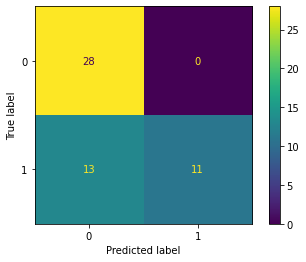

In [16]:
rfc = RandomForestClassifier()
rfc_scores = generate_predictions(rfc, 'rfc_basic')

In [17]:
get_feature_importances(rfc, x_train).sort_values('importance', ascending=False)

,feature,importance
4,hts_team.1,0.075250
3,hts_team,0.060712
8,gs_year,0.046339
13,gs_yards_off,0.039801
14,gs_pass_yds_off,0.039542
...,...,...
245,ats_punt_yds,0.000118
33,hts_points_opp,0.000054
126,hts_krtd,0.000000
252,ats_krtd,0.000000


# Support Vector Classifier

In [18]:
from sklearn.svm import SVC

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,acc,bacc,precision,recall
0,rfc_basic,0.750000,0.729167,1.0,0.458333
1,svc_basic,0.538462,0.500000,0.0,0.000000


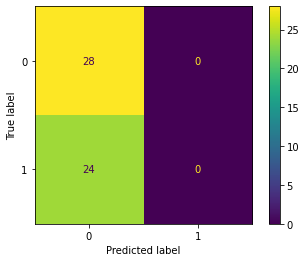

In [19]:
svc = SVC()
svc_scores = generate_predictions(svc, 'svc_basic')

# Gaussian Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB

,model_name,acc,bacc,precision,recall
0,rfc_basic,0.750000,0.729167,1.000000,0.458333
1,svc_basic,0.538462,0.500000,0.000000,0.000000
2,gaussian_nb_basic,0.673077,0.648810,0.888889,0.333333


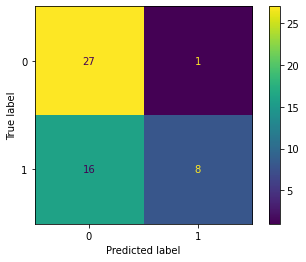

In [21]:
gaussian_nb = GaussianNB()
gaussian_nb_scores = generate_predictions(gaussian_nb, 'gaussian_nb_basic')

# Multi-layer perceptron
a.k.a sklearn's neural network

In [22]:
from sklearn.neural_network import MLPClassifier

,model_name,acc,bacc,precision,recall
0,rfc_basic,0.750000,0.729167,1.000000,0.458333
1,svc_basic,0.538462,0.500000,0.000000,0.000000
2,gaussian_nb_basic,0.673077,0.648810,0.888889,0.333333
3,mlp_basic,0.673077,0.651786,0.818182,0.375000


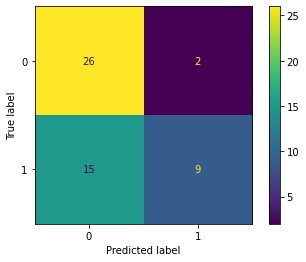

In [23]:
mlp = MLPClassifier()
mlp_scores = generate_predictions(mlp, 'mlp_basic')

# Keras sequential

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [25]:
keras_nn = Sequential()
keras_nn.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))

keras_nn.add(Dense(256, activation='relu'))
keras_nn.add(Dense(256, activation='relu'))
keras_nn.add(Dense(256, activation='relu'))

keras_nn.add(Dense(1, activation='sigmoid'))

keras_nn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)

keras_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               35712     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 200,577
Trainable params: 200,577
Non-trainable params: 0
_________________________________________________________________


2022-08-22 17:33:00.931299: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [26]:
keras_nn_fit_params = {
    'sequential__epochs': 100,
    'sequential__batch_size': 32,
    'sequential__verbose': 0, 
}

2022-08-22 17:33:01.257993: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


,model_name,acc,bacc,precision,recall
0,rfc_basic,0.750000,0.729167,1.000000,0.458333
1,svc_basic,0.538462,0.500000,0.000000,0.000000
2,gaussian_nb_basic,0.673077,0.648810,0.888889,0.333333
3,mlp_basic,0.673077,0.651786,0.818182,0.375000
4,keras_sequencial,0.653846,0.627976,0.875000,0.291667


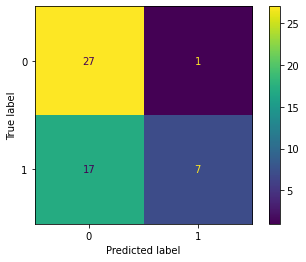

In [27]:
keras_nn_scores = generate_predictions(keras_nn, 'keras_sequencial', fit_params=keras_nn_fit_params)

---
---

# Investigações

Por algum motivo, as predições são melhores quando usamos o arquivo ```playoffs.csv```, em comparação ao arquivo preparado para a competição no workshop, ```df_kaggle_train.csv```

In [28]:
playoffs = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/playoffs.csv', sep=';')
playoffs.drop('Unnamed: 0', axis=1, inplace=True)
playoffs.rename({'gs_game_outcome': 'winorlose'}, axis=1, inplace=True)
playoffs = playoffs[playoffs['gs_game_location'].isin(['N', 'home'])]

kaggle_train = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_train.csv', sep=';')
kaggle_test = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_test.csv', sep=';')
kaggle_labels = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_test_labels.csv', sep=';')

In [29]:
playoffs[playoffs['gs_year'] == 2017][['gs_id', 'gs_team', 'gs_opp']]['gs_id']

185    4719
188    4779
189    4800
190    4925
194    4778
196    5120
200    5050
201    4799
202    4759
203    4996
204    5209
205    5208
Name: gs_id, dtype: int64

In [30]:
kaggle_train[kaggle_train['gs_year'] == 2017][['gs_id', 'gs_team', 'gs_opp']]['gs_id']

48    4719
49    4779
50    4800
51    4925
52    4778
53    5120
54    5050
55    4799
56    4759
57    4996
58    5209
59    5208
Name: gs_id, dtype: int64

In [31]:
bool(sum(kaggle_train[kaggle_train['gs_year'] == 2017][['gs_id', 'gs_team', 'gs_opp']]['gs_id'].values == \
playoffs[playoffs['gs_year'] == 2017][['gs_id', 'gs_team', 'gs_opp']]['gs_id'].values))

True

In [32]:
bool(sum(kaggle_test[kaggle_test['gs_year'] == 2020][['gs_id', 'gs_team', 'gs_opp']]['gs_id'].values == \
playoffs[playoffs['gs_year'] == 2020][['gs_id', 'gs_team', 'gs_opp']]['gs_id'].values))

True

Ambos os datasets possuem os mesmos jogos, mas quantidades de colunas diferentes.

In [33]:
playoffs.columns[~playoffs.columns.isin(kaggle_train.columns)]

Index(['gs_overtime', 'gs_team_record', 'gs_pts_off', 'gs_pts_def',
       'gs_first_down_off', 'gs_yards_off', 'gs_pass_yds_off',
       'gs_rush_yds_off', 'gs_to_off', 'gs_first_down_def', 'gs_yards_def',
       'gs_pass_yds_def', 'gs_rush_yds_def', 'gs_to_def', 'gs_exp_pts_off',
       'gs_exp_pts_def', 'gs_exp_pts_st', 'gs_is_playoff', 'hts_year',
       'hts_team', 'hts_team.1', 'ats_year', 'ats_team', 'ats_team.1'],
      dtype='object')

E aqui está a diferença.

```playoffs.csv``` contém colunas adicionais com informações sobre a partida.

Informações que não estariam disponíveis antes da partida acontecer, momento que seria feita uma predição.

Ou seja, ocorreu um vazamento de dados clássico.